In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [39]:
images = '../../datasets/greendino_new/images/'
depth = '../../datasets/greendino_new/depths/'
masks_colmap = '../../datasets/greendino_new/masks_colmap/'
masks_background = '../../datasets/greendino_new/masks_background/'
masks_hands = '../../datasets/greendino_new/masks_hands/'


if not os.path.exists(masks_colmap):
    os.makedirs(masks_colmap)
if not os.path.exists(masks_background):
    os.makedirs(masks_background)
if not os.path.exists(masks_hands):
    os.makedirs(masks_hands)

In [3]:
i=np.random.randint(0,len(os.listdir(images)),(1,))
name = os.listdir(images)[i.item()]
img = cv2.imread(images+name)
dpt = cv2.imread(depth+name.replace('.jpg','.png'), cv2.IMREAD_GRAYSCALE)

In [4]:
dpt.min(), dpt.max()

(0, 255)

In [5]:
dpt.shape

(1263, 1263)

112.0


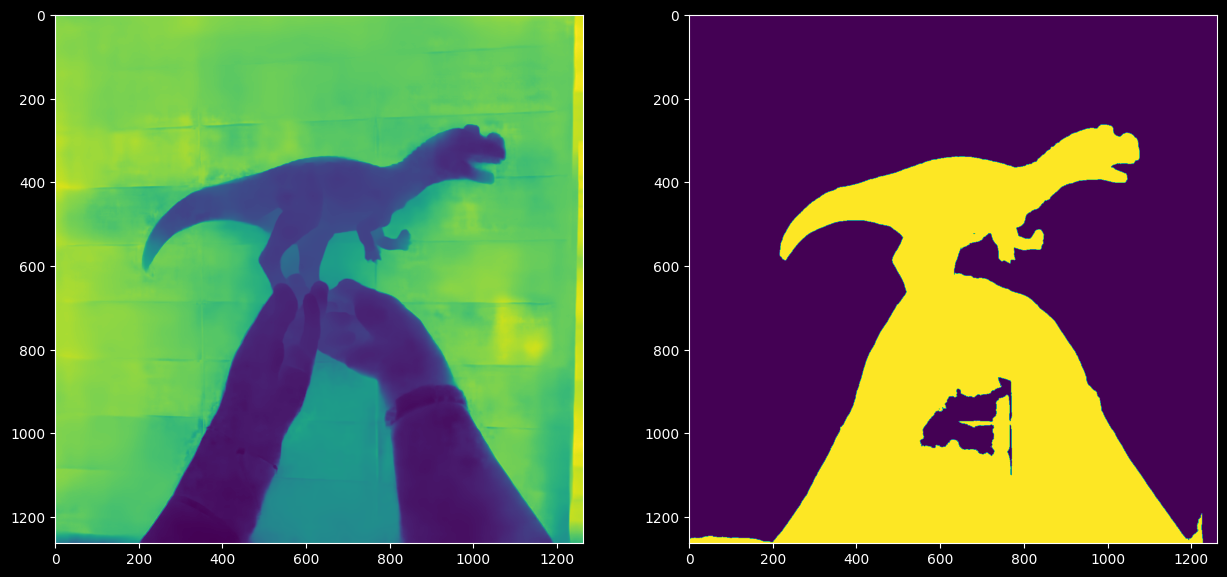

In [6]:
T, _ = cv2.threshold(dpt, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
print(T)
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(dpt)
plt.subplot(1,2,2)
plt.imshow(dpt<T+25)

In [7]:
mask=(dpt<(T+25))
mask.shape

(1263, 1263)

(1263, 1263)

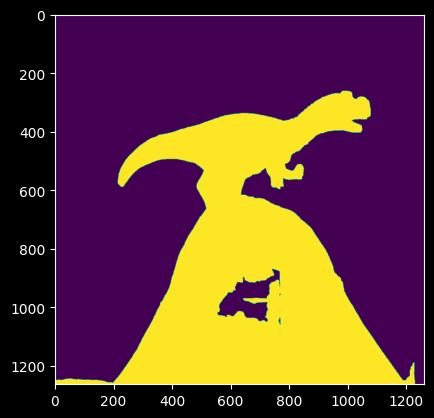

In [8]:
kernel=np.ones((5,5))
d=cv2.dilate(mask*1., kernel, iterations=1).astype(int)
plt.imshow(d)
d.shape

In [9]:
img.shape

(1263, 1263, 3)

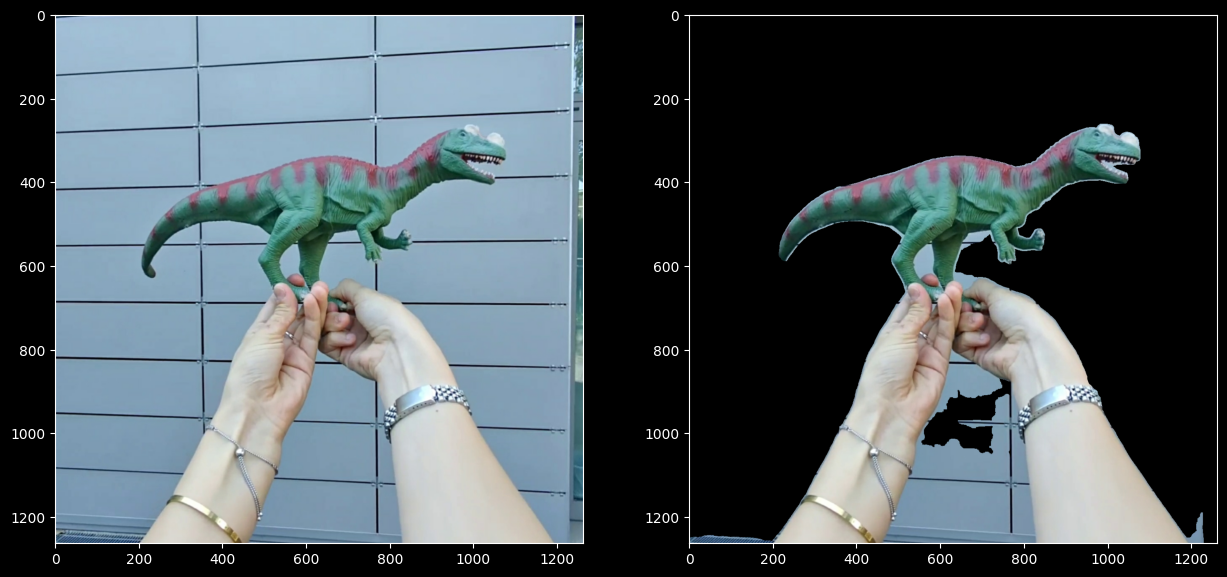

In [10]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(img[...,[2,1,0]])
plt.subplot(1,2,2)
plt.imshow(img[...,[2,1,0]]*d[...,None])

In [11]:
img.shape

(1263, 1263, 3)

In [12]:
import torch
import torch.hub

if not 'model' in locals():
    # Create the model
    model = torch.hub.load(
        repo_or_dir='guglielmocamporese/hands-segmentation-pytorch', 
        model='hand_segmentor', 
        pretrained=True
 )

c:\Users\Sam\miniconda3\envs\wisp1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in C:\Users\Sam/.cache\torch\hub\guglielmocamporese_hands-segmentation-pytorch_master
c:\Users\Sam\miniconda3\envs\wisp1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Sam\miniconda3\envs\wisp1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading...
From (uriginal): https://drive.google.com/uc?id=1w7dztGAsPHD_fl_Kv_a8qHL4eW92rlQg
From (redirected

In [13]:
imgt=torch.tensor(cv2.resize(img,(312,312))[...,[2,1,0]]).float().permute(2,0,1)[None]/255
imgt.shape

torch.Size([1, 3, 312, 312])

In [14]:
# Inference
model.eval()
preds = model(imgt) # [B, H, W]

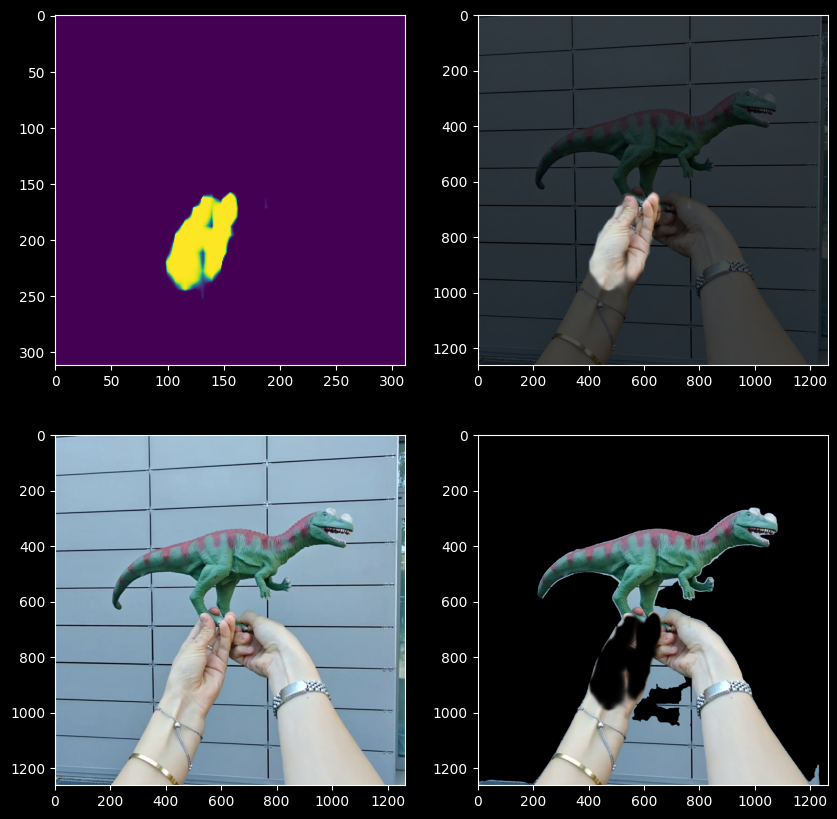

In [15]:
mask_hands=(torch.sigmoid((preds[0,1]-preds[0,0]))).detach().cpu()

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(mask_hands)
plt.subplot(2,2,2)
plt.imshow(img[...,[2,1,0]]/255*(0.3+0.7*cv2.resize((mask_hands).numpy(),img.shape[:-1])[...,None]))
plt.subplot(2,2,3)
plt.imshow(img[...,[2,1,0]])
plt.subplot(2,2,4)
plt.imshow(img[...,[2,1,0]]/255*d[...,None]*cv2.resize((1-mask_hands).numpy(),img.shape[:-1])[...,None])

In [74]:
C=50
kernel=np.ones((21,21))

for image in os.listdir(images):
    
    img = cv2.imread(images+image)
    dpt = cv2.imread(depth+image.replace('.jpg','.png'), cv2.IMREAD_GRAYSCALE)

    T, _ = cv2.threshold(dpt, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    mask=(dpt<(T+C))
    mask=cv2.dilate(mask*1., kernel, iterations=1).astype(int)

    imgt=torch.tensor(cv2.resize(img,(312,312))[...,[2,1,0]]).float().permute(2,0,1)[None]/255
    preds = model(imgt) 
    mask_hands=(torch.sigmoid((preds[0,1]-preds[0,0]))).detach().cpu()

    img = img * mask[:,:,None]
    cv2.imwrite(masks_colmap+image+".png", (mask[:,:,None] *cv2.resize((mask_hands<0.5).float().numpy(),img.shape[:-1])[...,None]*255).astype(np.uint8))
    cv2.imwrite(masks_background+image+".png", (mask[:,:,None]*255).astype(np.uint8))
    cv2.imwrite(masks_hands+image+".png", (cv2.resize((mask_hands>0.5).float().numpy(),img.shape[:-1]).astype(int)[...,None]*255).astype(np.uint8))
    print(image+".png")

0.jpg.png
1.jpg.png
10.jpg.png
106.jpg.png
107.jpg.png
108.jpg.png
109.jpg.png
111.jpg.png
115.jpg.png
116.jpg.png
117.jpg.png
118.jpg.png
123.jpg.png
124.jpg.png
125.jpg.png
126.jpg.png
127.jpg.png
128.jpg.png
129.jpg.png
13.jpg.png
130.jpg.png
131.jpg.png
132.jpg.png
133.jpg.png
134.jpg.png
135.jpg.png
136.jpg.png
137.jpg.png
138.jpg.png
139.jpg.png
14.jpg.png
140.jpg.png
141.jpg.png
142.jpg.png
143.jpg.png
144.jpg.png
146.jpg.png
148.jpg.png
149.jpg.png
15.jpg.png
150.jpg.png
151.jpg.png
152.jpg.png
157.jpg.png
158.jpg.png
16.jpg.png
160.jpg.png
161.jpg.png
163.jpg.png
164.jpg.png
165.jpg.png
166.jpg.png
167.jpg.png
169.jpg.png
170.jpg.png
171.jpg.png
173.jpg.png
174.jpg.png
175.jpg.png
177.jpg.png
178.jpg.png
179.jpg.png
180.jpg.png
181.jpg.png
182.jpg.png
183.jpg.png
184.jpg.png
193.jpg.png
195.jpg.png
196.jpg.png
197.jpg.png
199.jpg.png
200.jpg.png
201.jpg.png
202.jpg.png
203.jpg.png
204.jpg.png
205.jpg.png
206.jpg.png
207.jpg.png
208.jpg.png
209.jpg.png
210.jpg.png
212.jpg.png
2

In [71]:
mask.dtype

dtype('int32')

In [65]:
img_m=(cv2.resize((mask_hands>0.5).float().numpy(),img.shape[:-1])*255).astype(np.uint8)[...,None]

In [70]:
img_m.shape

(1263, 1263, 1)

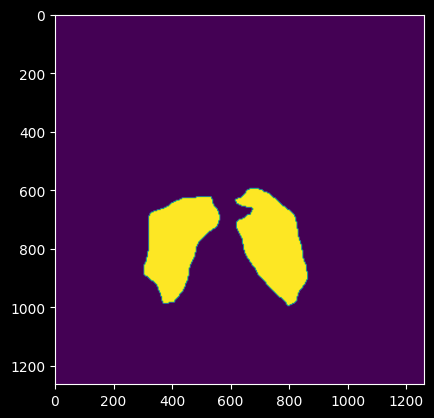

In [64]:
plt.imshow(mask[:,:,None])

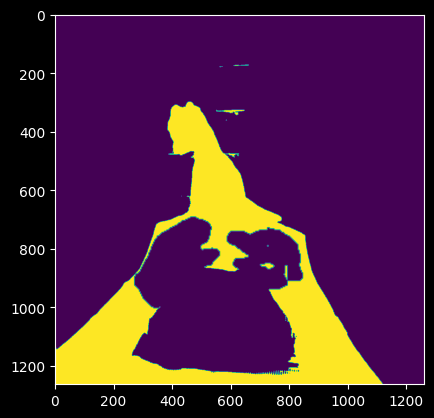

In [61]:
plt.imshow((mask[:,:,None] *cv2.resize((mask_hands<0.5).float().numpy(),img.shape[:-1])[...,None]))